![BTS](https://github.com/vfp1/bts-mbds-data-science-foundations-2019/raw/master/sessions/img/Logo-BTS.jpg)

# Session 11: EOlearn and TF
### Victor F. Pajuelo Madrigal <victor.pajuelo@bts.tech> - Advanced Data Analysis (08-06-2020)

Open this notebook in Google Colaboratory: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vfp1/bts-advanced-data-analysis-2020/blob/master/S11_EOLearn_TF_v2/11_Advanced_Data_Analysis_EOlearn_TF_2_NOTsolved.ipynb)

**Resources (code patched, refactored, updated and adapted from):**
* O'Reilly library
* ESA documentation
* EOlearn contributors


---



---

# A little recap my friends. What have we learned?

*   Tensorflow Basics
*   Tensorflow applied to market data
*   Tensorflow applied to time series
*   Spatial analysis
*   Tensorflow applied to spatial data



# Regarding the last exercise

Yes, I know, you are busy with the thesis. For the last exercise, I will ask you to return this notebook with another example of classification over the same dataset (more details will be given in class). We will see a complete version running on the cloud on our recurrent extra deploy classes :) 

# Install necessary libraries

In [1]:
!pip install geopandas

In [2]:
!pip install eo-learn

# EOlearn ETL

## Necessary imports

In [3]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from enum import Enum

# Basics of Python data handling and visualization
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm import tqdm_notebook as tqdm
import glob

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff, ImportFromTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

# Visualization
import pandas as pd
from shapely.geometry import Polygon

# Tensorflow
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


## GEOAI Refinery

### Folder locations
Change the paths to your convenience

In [0]:
# Subset high resolution
rgb_high_res = '/content/drive/My Drive/Work/BTS/Advanced Data Analysis/Session 11 - EOlearn and TF/data/raster_icgc.tif'

# Subset labels
labels = '/content/drive/My Drive/Work/BTS/Advanced Data Analysis/Session 11 - EOlearn and TF/data/labels.shp'

# Subset AOI
aoi = '/content/drive/My Drive/Work/BTS/Advanced Data Analysis/Session 11 - EOlearn and TF/data/aoi_smaller.shp'

# Subset Output Data
output_data = '/content/drive/My Drive/Work/BTS/Advanced Data Analysis/Session 11 - EOlearn and TF/prepared_data/'

# Subset Report
output_report = '/content/drive/My Drive/Work/BTS/Advanced Data Analysis/Session 11 - EOlearn and TF/reports/'

### Get AOI boundary

In [0]:
aoi_gdf = gpd.read_file(aoi)

#### Get the shapely polygon

In [0]:
# Get the country's shape in polygon format
# Get values
aoi_gdf_shape = aoi_gdf.geometry.values

# Get the shapely polygon
aoi_gdf_shape = [i for i in aoi_gdf_shape]

# Extract the shapely polygon
aoi_gdf_shape = aoi_gdf_shape[-1]

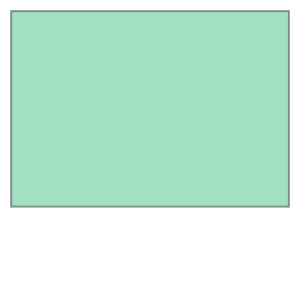

In [7]:
aoi_gdf_shape

#### Plot the AOI

Dimension of the area is 1261 x 888 meters


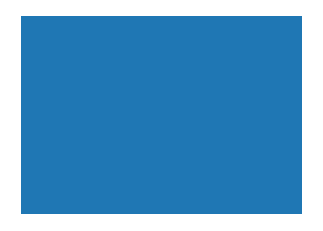

In [8]:
aoi_gdf.plot()
plt.axis('off')
print('Dimension of the area is {0:.0f} x {1:.0f} meters'.format(aoi_gdf_shape.bounds[2] - aoi_gdf_shape.bounds[0], 
                                                                 aoi_gdf_shape.bounds[3] - aoi_gdf_shape.bounds[1]))

#### Get AOI CRS

In [0]:
aoi_gdf_crs = aoi_gdf.crs

In [10]:
aoi_gdf_crs

<Projected CRS: EPSG:25831>
Name: ETRS89 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe - 0°E to 6°E and ETRS89 by country
- bounds: (0.0, 37.0, 6.01, 82.41)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Patching operations

The AOI will be tiled in 7 (columns) x 6 (rows).

In [0]:
bbox_splitter = BBoxSplitter([aoi_gdf_shape], aoi_gdf_crs, (7, 7))

In [12]:
print('Area bounding box: {}\n'.format(bbox_splitter.get_area_bbox().__repr__()))

Area bounding box: BBox(((342011.2739445117, 4724392.11259047), (343272.2846803377, 4725279.71723462)), crs=CRS('25831'))



In [13]:
bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

print('Each bounding box also has some info how it was created. Example:\n'
      '\nbbox: {}\ninfo: {}\n'.format(bbox_list[0].__repr__(), info_list[0]))

Each bounding box also has some info how it was created. Example:

bbox: BBox(((342011.2739445117, 4724392.11259047), (342191.418335344, 4724518.91325392)), crs=CRS('25831'))
info: {'parent_bbox': BBox(((342011.2739445117, 4724392.11259047), (343272.2846803377, 4725279.71723462)), crs=CRS('25831')), 'index_x': 0, 'index_y': 0}



In [14]:
len(bbox_splitter.bbox_list)

49

### Save the pickle splitter for latter use

#### Make directory if not exists

In [0]:
if not os.path.isdir(os.path.join(output_data, 'eolearn-tile-def')):
    os.makedirs(os.path.join(output_data, 'eolearn-tile-def'))

#### Make pickle

In [0]:
tile_df_folder = os.path.join(output_data, 'eolearn-tile-def')

with open(os.path.join(tile_df_folder, 'icgc_bbox_25831_7x6_42.pickle'),'wb') as fp:
    pickle.dump(bbox_splitter, fp)

### Visualize the selection

#### Patch indexes to DataFrame

In [17]:
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
idxs_y = [info['index_y'] for info in bbox_splitter.info_list]

df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
gdf = gpd.GeoDataFrame(df, crs={'init':CRS.ogc_string(bbox_splitter.bbox_list[0].crs)}, geometry=geometry)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [18]:
gdf.head()

,index_x,index_y,geometry
0,0,0,"POLYGON ((342011.274 4724392.113, 342011.274 4..."
1,0,1,"POLYGON ((342011.274 4724518.913, 342011.274 4..."
2,0,2,"POLYGON ((342011.274 4724645.714, 342011.274 4..."
3,0,3,"POLYGON ((342011.274 4724772.515, 342011.274 4..."
4,0,4,"POLYGON ((342011.274 4724899.315, 342011.274 4..."


#### Get labels as GeoDataFrame

In [0]:
labels_gdf = gpd.read_file(labels)

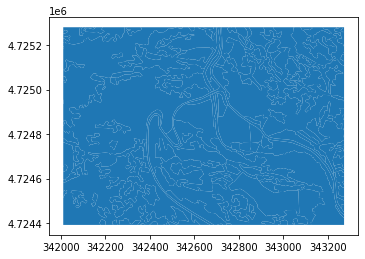

In [20]:
labels_gdf.plot()

#### Obtain patch ids

In [0]:
# Obtain patch ids
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    patchIDs.append(idx)

In [22]:
print(patchIDs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


#### Visualize the experiment area

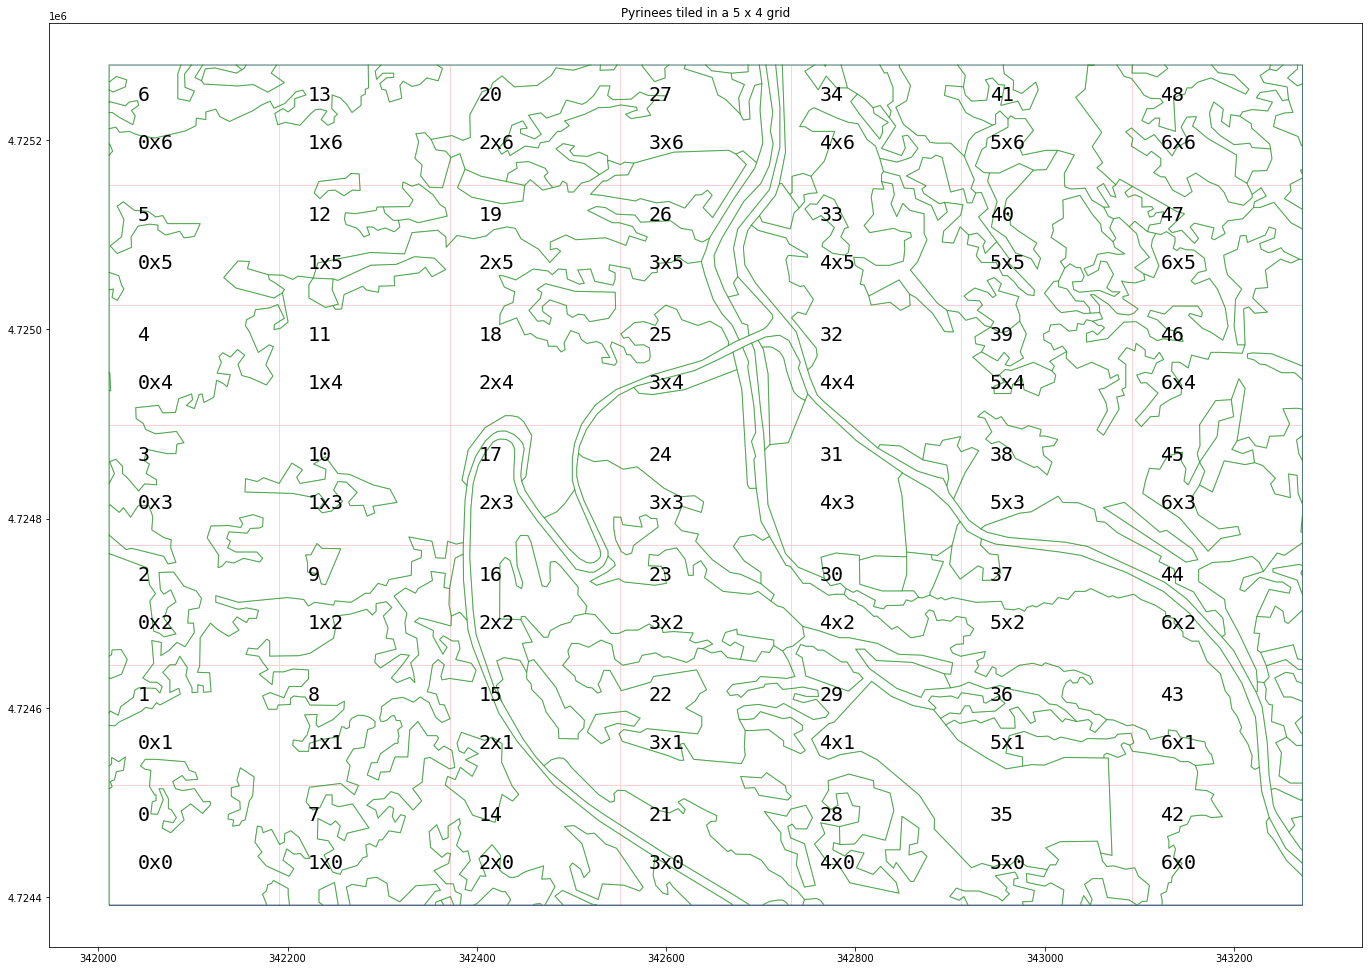

In [23]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 20}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu-xl)/3, (yu-yl)/5

# figure
fig, ax = plt.subplots(figsize=(25,17))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
aoi_gdf.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
labels_gdf.plot(ax=ax, facecolor='w',edgecolor='g',alpha=0.5)
ax.set_title('Pyrinees tiled in a 5 x 4 grid');

# add annotiation text
for idx in gdf.index:
    eop_name = '{0}x{1}'.format(gdf.index_x[idx], gdf.index_y[idx])
    centroid, = list(gdf.geometry[idx].centroid.coords)
    ax.text(centroid[0]-xoff, centroid[1]+yoff, '{}'.format(idx), fontdict=fontdict)
    ax.text(centroid[0]-xoff, centroid[1]-yoff, eop_name, fontdict=fontdict)

if not os.path.isdir(os.path.join(output_data, 'figs')):
    os.makedirs(os.path.join(output_data, 'figs'))
fig.savefig(os.path.join(output_data, 'figs/aoi_to_tiles.png'), bbox_inches='tight')

#### Open BBoxSplitter with tile definitions

In [0]:
with open(os.path.join(tile_df_folder, 'icgc_bbox_25831_7x6_42.pickle'),'rb') as fp:
    bbox_splitter = pickle.load(fp)

##### Get lenght of bbox_list

In [25]:
len(bbox_splitter.bbox_list)

49

##### Print geometries from bbox

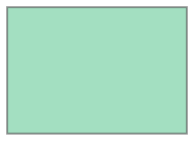

In [26]:
bbox_splitter.bbox_list[1]

##### Get bbox splitter bbox

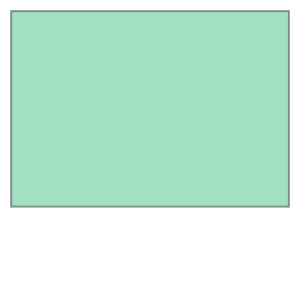

In [27]:
bbox_splitter.get_area_bbox()

In [28]:
bbox_splitter.get_area_bbox().crs

CRS('25831')

# EOlearn IO tasks

## Configure EOlearn workflow

### Configuring sentinelhub

In [29]:
!sentinelhub.config --show

{
  "instance_id": "instance_colab",
  "sh_client_id": "",
  "sh_client_secret": "",
  "sh_base_url": "https://services.sentinel-hub.com",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 4,
  "download_sleep_time": 5,
  "download_timeout_seconds": 120,
  "number_of_download_processes": 1
}
Configuration file location: /usr/local/lib/python3.6/dist-packages/sentinelhub/config.json


In [0]:
! sentinelhub.config --instance_id 'instance_colab'

### EOPatch workflow

#### Getting to know our labels

In [87]:
geodf_label = gpd.read_file(labels)
a = geodf_label['nivell_2'].unique()
print(sorted(a))

[111, 222, 224, 226, 228, 229, 230, 232, 341, 344, 346, 351, 352, 461, 463]


In [88]:
geodf_label

,fid,id,nivell_2,geometry
0,10.0,10.0,351,"POLYGON ((342715.677 4725279.717, 342722.784 4..."
1,260834.0,260834.0,224,"MULTIPOLYGON (((342472.180 4724392.113, 342468..."
2,1265198.0,1265211.0,222,"MULTIPOLYGON (((342011.274 4724392.113, 342011..."
3,1265343.0,1265356.0,222,"MULTIPOLYGON (((342722.784 4725279.717, 342757..."
4,1164856.0,1164867.0,228,"POLYGON ((342011.274 4725041.849, 342011.274 4..."
...,...,...,...,...
145,820065.0,820073.0,232,"POLYGON ((343272.285 4724485.680, 343272.285 4..."
146,1265433.0,1265446.0,222,"POLYGON ((343018.397 4724392.113, 342977.299 4..."
147,260865.0,260865.0,224,"POLYGON ((343238.564 4725279.717, 343252.121 4..."
148,20206.0,20206.0,344,"POLYGON ((342156.553 4725279.717, 342188.638 4..."


#### Remapping those values (too high range)

In [89]:
from collections import defaultdict

dict_change = defaultdict(list)

for idx, val in enumerate(sorted(a)):
    if val > 100 and val < 200:
        dict_change[val].append(0)
    elif val > 200 and val < 300:
        dict_change[val].append(1)
    elif val > 300 and val < 400:
        dict_change[val].append(0)
    elif val > 400:
        dict_change[val].append(0)

dict_change

defaultdict(list,
            {111: [0],
             222: [1],
             224: [1],
             226: [1],
             228: [1],
             229: [1],
             230: [1],
             232: [1],
             341: [0],
             344: [0],
             346: [0],
             351: [0],
             352: [0],
             461: [0],
             463: [0]})

In [90]:
geodf_label = geodf_label.replace({'nivell_2': dict_change})
geodf_label

,fid,id,nivell_2,geometry
0,10.0,10.0,0,"POLYGON ((342715.677 4725279.717, 342722.784 4..."
1,260834.0,260834.0,1,"MULTIPOLYGON (((342472.180 4724392.113, 342468..."
2,1265198.0,1265211.0,1,"MULTIPOLYGON (((342011.274 4724392.113, 342011..."
3,1265343.0,1265356.0,1,"MULTIPOLYGON (((342722.784 4725279.717, 342757..."
4,1164856.0,1164867.0,1,"POLYGON ((342011.274 4725041.849, 342011.274 4..."
...,...,...,...,...
145,820065.0,820073.0,1,"POLYGON ((343272.285 4724485.680, 343272.285 4..."
146,1265433.0,1265446.0,1,"POLYGON ((343018.397 4724392.113, 342977.299 4..."
147,260865.0,260865.0,1,"POLYGON ((343238.564 4725279.717, 343252.121 4..."
148,20206.0,20206.0,0,"POLYGON ((342156.553 4725279.717, 342188.638 4..."


In [0]:
geodf_label.to_file('/content/drive/My Drive/Work/BTS/Advanced Data Analysis/Session 11 - EOlearn and TF/data/labels_refined.geojson', driver='GeoJSON')


In [92]:
geodf_label['nivell_2'].max()

1

In [93]:
geodf_label['nivell_2'].min()

0

#### Build up the EOlearn task classes

In [0]:
from eolearn.core import EOPatch

class EmptyEOPatch(EOTask):   
    """
    Creates an empty geopatch
    """
    def __init__(self, bounding_box):
        self.bounding_box = bounding_box
    
    def execute(self, bounding_box):
        eopatch = EOPatch()
        eopatch.set_bbox(bounding_box)

        return eopatch

class FillEOPatchRGB(EOTask):
    """
    Fills EOPatch with RGB
    """
    def __init__(self, patch, rgb):
        self.patch = patch
        self.rgb = rgb
    
    def execute(self, patch):
        eopatch = ImportFromTiff(feature=(FeatureType.DATA, 'RGB'), 
                                no_data_value=np.nan)
        eopatch.execute(eopatch=patch, filename=self.rgb)

        # Patch gets updated, need to return this
        return patch
    
class LULC(Enum):
    No_data = (0, 'No_data', 'beige')
    Forest = (1, 'Forest', 'xkcd:darkgreen')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

class FillEOPatchLabels(EOTask):
    """
    Fills EOPatch with labels
    """
    def __init__(self, patch, gdf, feature_column, nodataval):
        """
        Init variables

        :param patch: This is a patch coming from another EOTask
        :param gdf: This is the GeoDF with the labels
        """
        self.patch = patch
        self.gdf = gdf
        self.feature_column = feature_column
        self.nodataval = nodataval
    
    def execute(self, patch):

        rasterized_annotation = VectorToRaster(vector_input=self.gdf, 
                                               raster_feature=(FeatureType.MASK_TIMELESS, 'LULC'), 
                                               values_column=self.feature_column,
                                               raster_shape=(FeatureType.DATA, 'RGB'),
                                               no_data_value=self.nodataval,
                                               raster_dtype=np.uint16)
        rasterized_annotation.execute(eopatch=patch)

        # Patch gets updated, need to return this
        return patch

class SaveEOPatch(EOTask):
    """
    Save a Patch
    """
    def __init__(self, input_patch, output_folder):
        self.input_patch = input_patch
        self.output_folder = output_folder
    
    def execute(self, input_patch, output_folder):
        if not os.path.isdir(output_folder):
            os.makedirs(output_folder)

        input_patch.save(path=output_folder, overwrite_permission=1)

        return input_patch

In [0]:
eopatch_path = os.path.join(output_data, 'epotach')

if not os.path.isdir(eopatch_path):
    os.makedirs(eopatch_path)

#### Build workflow

In [96]:
[entry.class_name for entry in LULC]

['No_data', 'Forest']

In [97]:
[entry.color for entry in LULC]

['beige', 'xkcd:darkgreen']

In [0]:
## Define tasks per workflow

eopatch = EmptyEOPatch(bounding_box=bbox_splitter.get_area_bbox())

rgb_patch = FillEOPatchRGB(patch=eopatch, rgb=rgb_high_res)

## Define map colors
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_cmap.set_over('white')
lulc_cmap.set_under('white')

bounds = np.arange(-0.5, 2, 1).tolist()
lulc_norm = mpl.colors.BoundaryNorm(bounds, lulc_cmap.N)
                                    
## Define labels
label_patch = FillEOPatchLabels(patch=rgb_patch, 
                                gdf=geodf_label, 
                                feature_column='nivell_2', 
                                nodataval=0)

save = SaveEOPatch(input_patch=label_patch, output_folder=eopatch_path)

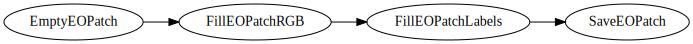

In [116]:
# Define the workflow
workflow = LinearWorkflow(eopatch, rgb_patch, label_patch, save)

# Let's visualize it
workflow.dependency_graph()

#### Run example executor

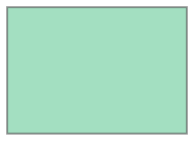

In [117]:
bbox_splitter.bbox_list[4]

In [0]:
execution_args = []

execution_args.append({
    eopatch: {'bounding_box': bbox_splitter.bbox_list[4]},
    save: {'output_folder': os.path.join(eopatch_path, 'eopatch_{}'.format(4))}
})

In [119]:
example_executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder=output_report)
example_executor.run(workers=5, multiprocess=True)

example_executor.make_report()

#### Run execution args

In [120]:
%%time

# Execute the workflow
# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_splitter.bbox_list):
    execution_args.append({
        eopatch: {'bounding_box': bbox},
        save: {'output_folder': os.path.join(eopatch_path, 'eopatch_{}'.format(idx))}
    })

CPU times: user 154 µs, sys: 0 ns, total: 154 µs
Wall time: 159 µs


#### Run Eolearn executor

In [121]:
executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder=output_report)
executor.run(workers=5, multiprocess=True)

executor.make_report()

# Dataset visualization

## Dataset Testing

In [0]:
eopatch = EOPatch.load('{}/eopatch_5'.format(eopatch_path), lazy_loading=True)

In [106]:
eopatch

EOPatch(
  data: {
    RGB: FeatureIO(/data/RGB.npy)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: FeatureIO(/mask_timeless/LULC.npy)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((342011.2739445117, 4725026.11590772), (342191.418335344, 4725152.91657117)), crs=CRS('25831'))
  timestamp: []
)

In [107]:
eopatch.data['RGB'].min()

0

In [108]:
eopatch.mask_timeless['LULC'].min()

1

In [109]:
eopatch.mask_timeless['LULC'].max()

1

In [110]:
eopatch.mask_timeless['LULC'].shape

(508, 721, 1)

In [111]:
eopatch.data['RGB'].shape

(1, 508, 721, 3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


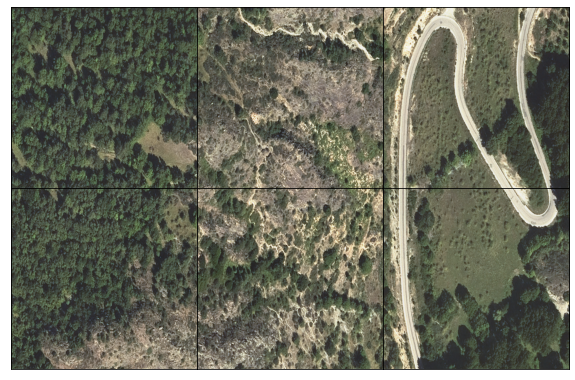

In [112]:
# Draw the RGB image
fig = plt.figure(figsize=(10, 10))

list_tiles = [5, 11, 17, 4, 10, 16]
pbar = tqdm(total=len(list_tiles))

for idx, val in enumerate(list_tiles):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(eopatch_path, val), lazy_loading=True)
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(eopatch.data['RGB'][0].astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

In [113]:
[entry.color for entry in LULC]

['beige', 'xkcd:darkgreen']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


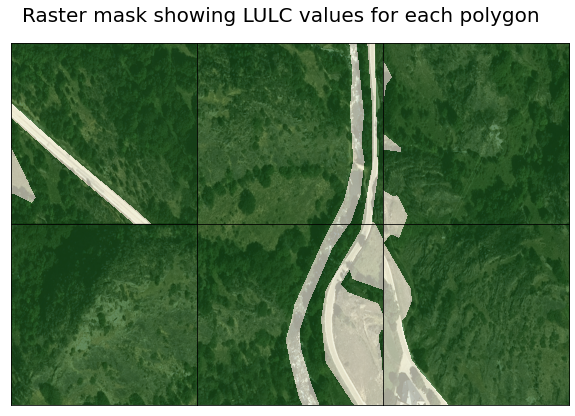

In [122]:
# Draw the LABEL images
fig = plt.figure(figsize=(10, 10))

list_tiles = [21, 27, 33, 20, 26, 32]
pbar = tqdm(total=len(list_tiles))

for idx, val in enumerate(list_tiles):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(eopatch_path, val), lazy_loading=True)
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(eopatch.data['RGB'][0].astype(np.uint8))
    lulc_classes = ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), alpha=0.6, cmap=lulc_cmap, norm=lulc_norm)
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

fig.suptitle('Raster mask showing LULC values for each polygon', y=0.93, size=20)

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


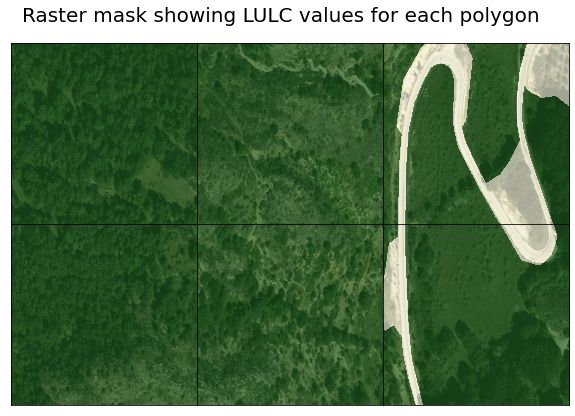

In [123]:
# Draw the LABEL images
fig = plt.figure(figsize=(10, 10))

list_tiles = [5, 11, 17, 4, 10, 16]
pbar = tqdm(total=len(list_tiles))

for idx, val in enumerate(list_tiles):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(eopatch_path, val), lazy_loading=True)
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(eopatch.data['RGB'][0].astype(np.uint8))
    lulc_classes = ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), alpha=0.6, cmap=lulc_cmap, norm=lulc_norm)
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

fig.suptitle('Raster mask showing LULC values for each polygon', y=0.93, size=20)

plt.show()

In [0]:
eopatch_example = EOPatch.load('{}/eopatch_10'.format(eopatch_path), lazy_loading=True)

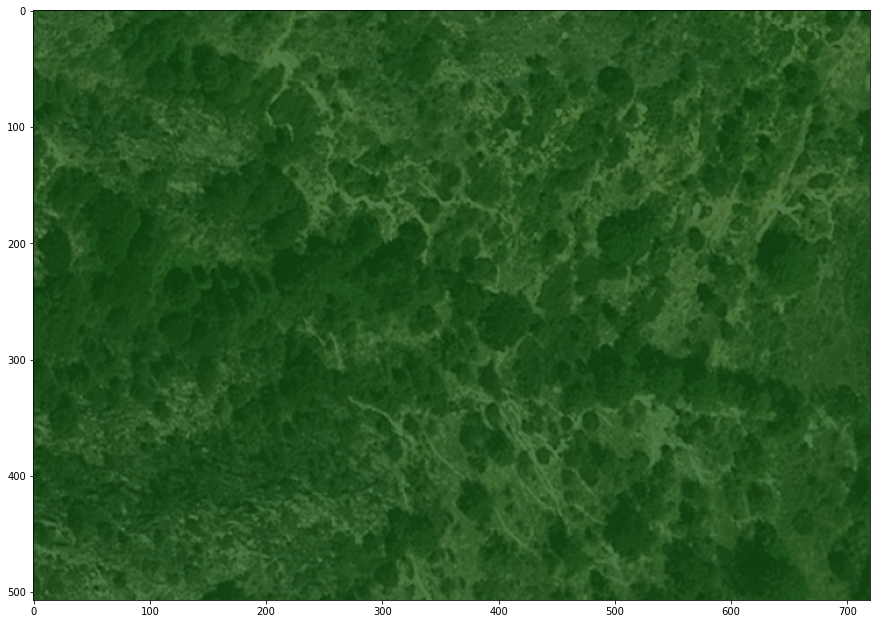

In [56]:
data = eopatch_example.data['RGB'][0].astype(np.uint8)
plt.figure(figsize=(15,15))
plt.imshow(data)

lulc_classes = eopatch_example.mask_timeless['LULC'].squeeze()
plt.imshow(lulc_classes, alpha=.7, cmap=lulc_cmap, norm=lulc_norm)

### Export to tiff

In [63]:
eopatch_example5 = EOPatch.load('{}/eopatch_5'.format(eopatch_path), lazy_loading=True)

ExportToTiff(feature=(FeatureType.DATA, 'RGB')).execute(eopatch_example5, 
                                                        filename=os.path.join(output_data, '5_data.tif'))

EOPatch(
  data: {
    RGB: numpy.ndarray(shape=(1, 508, 721, 3), dtype=uint8)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: FeatureIO(/mask_timeless/LULC.npy)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((342011.2739445117, 4725026.11590772), (342191.418335344, 4725152.91657117)), crs=CRS('25831'))
  timestamp: []
)

In [64]:
ExportToTiff(feature=(FeatureType.MASK_TIMELESS, 'LULC')).execute(eopatch_example5, 
                                                        filename=os.path.join(output_data, '5_label.tif'))

EOPatch(
  data: {
    RGB: numpy.ndarray(shape=(1, 508, 721, 3), dtype=uint8)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: numpy.ndarray(shape=(508, 721, 1), dtype=uint16)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((342011.2739445117, 4725026.11590772), (342191.418335344, 4725152.91657117)), crs=CRS('25831'))
  timestamp: []
)

# Prepare dataset for training

The patches are split into a train and test subset, where we take the patch with ID = 1 for testing, since it seems a good representative of the area.

The test sample is hand picked because of the small set of patches, otherwise with a larged overall set, the training and testing patches should be randomly chosen.

The sampled features and labels are loaded and reshaped into $n \times m$, where $n$ represents the number of training pixels, and $m = f \times t$ the number of all features, with $f$ the size of bands and band combinations  and $t$ the length of the resampled time-series

In [124]:
subset_idx = len(bbox_splitter.bbox_list)

for i in range(0, subset_idx):
    eop = EOPatch.load('{}/eopatch_{}'.format(eopatch_path, i), lazy_loading=True)
    print(eop.data['RGB'].shape)


(1, 508, 721, 3)
(1, 507, 721, 3)
(1, 507, 721, 3)
(1, 507, 721, 3)
(1, 507, 721, 3)
(1, 508, 721, 3)
(1, 507, 721, 3)
(1, 508, 720, 3)
(1, 507, 720, 3)
(1, 507, 720, 3)
(1, 507, 720, 3)
(1, 507, 720, 3)
(1, 508, 720, 3)
(1, 507, 720, 3)
(1, 508, 721, 3)
(1, 507, 721, 3)
(1, 507, 721, 3)
(1, 507, 721, 3)
(1, 507, 721, 3)
(1, 508, 721, 3)
(1, 507, 721, 3)
(1, 508, 720, 3)
(1, 507, 720, 3)
(1, 507, 720, 3)
(1, 507, 720, 3)
(1, 507, 720, 3)
(1, 508, 720, 3)
(1, 507, 720, 3)
(1, 508, 721, 3)
(1, 507, 721, 3)
(1, 507, 721, 3)
(1, 507, 721, 3)
(1, 507, 721, 3)
(1, 508, 721, 3)
(1, 507, 721, 3)
(1, 508, 721, 3)
(1, 507, 721, 3)
(1, 507, 721, 3)
(1, 507, 721, 3)
(1, 507, 721, 3)
(1, 508, 721, 3)
(1, 507, 721, 3)
(1, 508, 720, 3)
(1, 507, 720, 3)
(1, 507, 720, 3)
(1, 507, 720, 3)
(1, 507, 720, 3)
(1, 508, 720, 3)
(1, 507, 720, 3)


### Dataset Generator

In [0]:
# load sampled eopatches
eopatches = []
subset_idx = len(bbox_splitter.bbox_list)

for i in range(0, subset_idx):
    eopatches.append(EOPatch.load('{}/eopatch_{}'.format(eopatch_path, i), lazy_loading=True))    

eopatches = np.array(eopatches)

In [126]:
eop = EOPatch.load('{}/eopatch_11'.format(eopatch_path), lazy_loading=True)
eop.data['RGB'].shape

(1, 507, 720, 3)

#### X_train and X_test splits

In [0]:
from sklearn.model_selection import train_test_split

id_list = [i for i in np.arange(0, len(eopatches))]

X_train, X_test, y_train, y_test = train_test_split(id_list, id_list, test_size=0.33, random_state=42)

In [128]:
X_train

[41,
 46,
 15,
 9,
 16,
 24,
 33,
 30,
 0,
 43,
 32,
 5,
 29,
 11,
 36,
 1,
 21,
 2,
 37,
 35,
 23,
 39,
 10,
 22,
 18,
 48,
 20,
 7,
 42,
 14,
 28,
 38]

In [129]:
X_test

[13, 45, 47, 44, 17, 27, 26, 25, 31, 19, 12, 4, 34, 8, 3, 6, 40]

In [130]:
len(X_train)

32

#### Utility functions and sliding windows

In [0]:
def get_random_pos(img, window_shape, desired_width, desired_height):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W = desired_width
    H = desired_height
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

##### Testing random position

In [132]:
X = np.empty((507, 720, 3))
y = np.empty((507, 720))

# Load eopatch from random idx
eopatch = EOPatch.load('{}/eopatch_{}'.format(eopatch_path, 6), lazy_loading=True)

X = eopatch.data['RGB'][0].astype(np.uint8)
y = eopatch.mask_timeless['LULC'].squeeze()

print(X.shape)
print(y.shape)

del eopatch

(507, 721, 3)
(507, 721)


In [133]:
x1, x2, y1, y2 = get_random_pos(X, (128, 128), DESIRED_SIZE_WIDTH, DESIRED_SIZE_HEIGHT)
print(x1, x2, y1, y2)

137 265 155 283


In [0]:
X_p = X[x1:x2,y1:y2, :]
y_p = y[x1:x2,y1:y2]

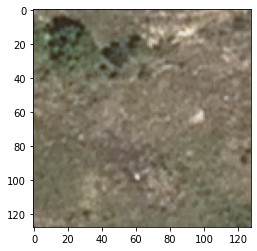

In [135]:
plt.imshow(X_p)

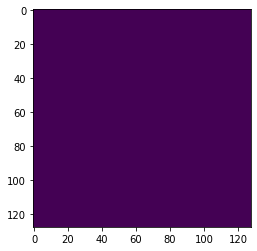

In [136]:
plt.imshow(y_p)

#### Our cool DataGenerator

In [0]:
import numpy as np
import keras
import random
from tensorflow.keras.utils import Sequence
from IPython.display import clear_output

class LULCDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, eopatch_path, list_IDs, n_classes, desired_width, desired_height, 
                 batch_size=1, n_channels=3, shuffle=True, window_size=(256, 256)):
        'Initialization'
        self.eopatch_path = eopatch_path
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

        # Setting desired with and lenght
        self.desired_width = desired_width
        self.desired_height = desired_height

        # Window size
        """
        The window size tuple should be always divisible by 32!
        """
        self.window_size = window_size
        self.w, self.h = window_size

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        # Indexes
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        """
        ----------------------------------------------------------------
        Batch Management
        """
        batch_images = np.zeros((len(indexes), self.w, self.h, 3), dtype=np.float32)
        batch_labels = np.zeros((len(indexes), self.w, self.h), dtype=np.uint16)


        """
        Return tensors
        """
        # Generate data
        X, y = self.__batch_generation(random_idx=list_IDs_temp, 
                                       batch_x=batch_images, 
                                       batch_y=batch_labels,
                                       indexes_lenght=len(indexes))
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)        

    def __batch_generation(self, random_idx, batch_x, batch_y, indexes_lenght):

        for i, ID in enumerate(random_idx):
            eopatch = EOPatch.load('{}/eopatch_{}'.format(self.eopatch_path, ID), 
                                   lazy_loading=True)
            
            # Data is normalized in [0, 1]
            # Resize data
            X = 1/255 * eopatch.data['RGB'][0].astype(np.float32)
            y = eopatch.mask_timeless['LULC'].squeeze()

            # Get random window
            x1, x2, y1, y2 = get_random_pos(X, self.window_size, 
                                            self.desired_width, self.desired_height)
            
            # Set according to shape
            X_window = X[x1:x2,y1:y2,:]
            y_window = y[x1:x2,y1:y2]           

            # Store sample
            batch_x[i,] = X_window

            # Store class
            batch_y[i] = y_window

            del eopatch
            del X
            del y 

        return batch_x, batch_y

### Define the UNET

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Cropping2D, Flatten, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers


In [0]:
def unet(input_size):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(conv1)
    batch1 = BatchNormalization(axis=3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(conv2)
    batch2 = BatchNormalization(axis=3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(conv3)
    batch3 = BatchNormalization(axis=3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(conv4)
    batch4 = BatchNormalization(axis=3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(conv9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(len([entry.class_name for entry in LULC]), 1, activation = 'softmax')(conv9)  
    """
    dense1 = Dense(64, activation='relu')(conv9)
    dense2 = Dense(32, activation='relu')(dense1)
    dense3 = Dense(16, activation='relu')(dense2)
    dense4 = Dense(len([entry.class_name for entry in LULC]), activation='relu')(dense3)
    dense5 = Dense(1, activation='softmax')(dense4)
    """

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-6), 
                  loss = "sparse_categorical_crossentropy", 
                  metrics = ['accuracy'])

    return model

In [0]:
w, h = WINDOW_SIZE

model = unet(input_size = (w, h, 3))

# Train dataset

Feel free to try with different optimizers if your training does not look too good

## Using the DataGenerator

In [0]:
DESIRED_SIZE_WIDTH = 507
DESIRED_SIZE_HEIGHT = 720

WINDOW_SIZE = (256, 256) # Patch size
STRIDE = 32 # Stride for testing

In [0]:
training_generator = LULCDataGenerator(eopatch_path=eopatch_path, 
                                   list_IDs=X_train,
                                   n_classes=len([entry.class_name for entry in LULC]), 
                                   desired_width=DESIRED_SIZE_WIDTH, 
                                   desired_height=DESIRED_SIZE_HEIGHT)

In [0]:
validation_generator = LULCDataGenerator(eopatch_path=eopatch_path, 
                                   list_IDs=X_test,
                                   n_classes=len([entry.class_name for entry in LULC]), 
                                   desired_width=DESIRED_SIZE_WIDTH, 
                                   desired_height=DESIRED_SIZE_HEIGHT)

## Defining our own callback function

In [0]:
import tensorflow as tf
import keras
import random
import matplotlib.pyplot as plt
import numpy as np

class WhileTrainPrediction(tf.keras.callbacks.LambdaCallback):
    def __init__(self, eopatch_path, test_ids, window_size, desired_width, desired_height):
        self.eopatch_path = eopatch_path
        self.test_ids = test_ids
        self.window_size = window_size
        self.desired_width = desired_width 
        self.desired_height = desired_height

        self.w, self.h = window_size


    def __get_images(self):
        eopatch = EOPatch.load('{}/eopatch_{}'.format(self.eopatch_path, random.choice(self.test_ids)), lazy_loading=True)
        
        # Data is normalized in [0, 1]
        # Resize data
        X = eopatch.data['RGB'][0].astype(np.uint8)
        X_scaled = 1/255 * X
        y = eopatch.mask_timeless['LULC'].squeeze()

        # Get random window
        x1, x2, y1, y2 = get_random_pos(X_scaled, self.window_size, 
                                        self.desired_width, self.desired_height)
        
        # Set according to shape
        X_window_scaled = X_scaled[x1:x2,y1:y2,:]
        X_window_scaled = np.resize(X_window_scaled, (1, self.w, self.h, 3))
        X_window_normal = X_scaled[x1:x2,y1:y2,:]      
        y_window = y[x1:x2,y1:y2]

        del eopatch

        return X_window_scaled, X_window_normal, y_window    

    def on_train_begin(self, logs={}):
        self.fig = plt.figure()
    
    def on_epoch_end(self, epoch, logs={}):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
        
        X_scaled, X_normal, y = self.__get_images()

        y_pred = self.model.predict(X_scaled)

        p = np.argmax(y_pred, axis=3)

        ax1.imshow(X_normal)
        ax1.set_title("RGB")
        ax2.imshow(y, cmap=lulc_cmap, norm=lulc_norm)
        ax2.set_title("Ground Truth")
        ax3.imshow(p.squeeze(), cmap=lulc_cmap, norm=lulc_norm)
        ax3.set_title("Prediction")
        plt.show;

## Printing model summary

In [0]:
model.summary()

## Training!

Epoch 1/2
32/32 - 4s - loss: 6.5224 - accuracy: 0.9252 - val_loss: 6.6671 - val_accuracy: 0.8634
Epoch 2/2
32/32 - 4s - loss: 6.6278 - accuracy: 0.8864 - val_loss: 6.5608 - val_accuracy: 0.9150


<Figure size 432x288 with 0 Axes>

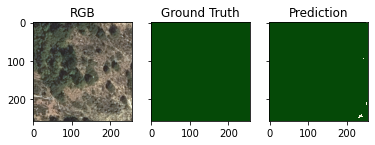

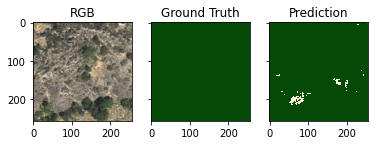

In [308]:
%matplotlib inline

print_callback = WhileTrainPrediction(eopatch_path=eopatch_path, 
                                      test_ids=X_test, 
                                      window_size=WINDOW_SIZE, 
                                      desired_width=DESIRED_SIZE_WIDTH, 
                                      desired_height = DESIRED_SIZE_HEIGHT)

model.fit(x=training_generator, 
        validation_data=validation_generator, 
        verbose=2, 
        epochs=2, 
        callbacks=[print_callback])

# Validate model and show results

In [233]:
predict = model.predict_generator(validation_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [234]:
len(predict)

17

In [235]:
X_test[4]

17

In [0]:
eop = EOPatch.load('{}/eopatch_{}'.format(eopatch_path, X_test[4]), lazy_loading=True)

In [0]:
label = eop.mask_timeless['LULC'].squeeze()

In [238]:
label.shape

(507, 721)

In [0]:
img = eop.data['RGB'][0].astype(np.uint8)

In [240]:
predict[4].shape

(256, 256, 2)

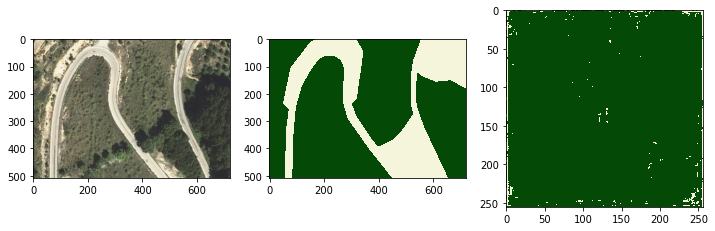

In [241]:
p = np.argmax(predict, axis=3)
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img)
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(label, cmap=lulc_cmap, norm=lulc_norm)
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(p[4], cmap=lulc_cmap, norm=lulc_norm)

# Your turn

Alright, we still need to reapply this to EOpatch. We will see that in deployment class. However, the network can be tuned a lot more, and we can cherry pick our training data to represent the other classes. Furthermore, you can add different losses. 

Go ahead and try it out. Return this notebook with your trials.